### Sequential neural posterior estimation
Below shows an example of sequential neural posterior estimation (SNPE). SNPE uses multiple
rounds of simulations, in which posterior estimates from each round are used as proposal
distributions for the subsequent round. This can lead to much higher simulation efficiency
compared to a single round approach. The variant of SNPE used here is often referred to as SNPE-C, as described by [Greenberg et al. (2019)](https://arxiv.org/abs/1905.07488) and [Durkan et al. (2020)](https://arxiv.org/abs/2002.03712).


In [7]:
import numpyro.distributions as ndist
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx

from flowjax.train.data_fit import fit_to_data_sequential
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.distributions import Normal
import flowjax.bijections as bij

The task we consider is to infer the mean of a mixture of two two-dimensional Normal distributions, in which one of the distributions has a much broader variance. We define this model using numpyro.

In [8]:
def model(x_obs=None):
    with numpyro.plate("task_dim", 2):
        theta = numpyro.sample("theta", ndist.Normal(0, 0.5))
        component = numpyro.sample("c", ndist.Categorical(jnp.array([0.5])), infer={"enumerate": "parallel"})
        scale = jnp.where(component==0, 0.02, 0.2)
        numpyro.sample("x", ndist.Normal(theta, scale), obs=x_obs)

key, subkey = jr.split(jr.PRNGKey(1))
x_obs = Predictive(model, num_samples=1)(subkey)["x"][0]

We use an affine masked autoregressive flow as our proposal/posterior estimator

In [9]:
key, subkey = jr.split(key)
proposal = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(2), 0.5),
    transformer=bij.Affine(),
    cond_dim=x_obs.size,
    nn_depth=1,
    flow_layers=4,
    )

Carrying out SNPE using 2 rounds of simulations. 

In [10]:
def simulate(key, theta):
    predictive = numpyro.infer.Predictive(model, {"theta": theta})
    return predictive(key)["x"]

sim_per_round = 500
prior = Normal(jnp.zeros(2))  # Matches prior from the model

data = {
    "theta": [],
    "x_sim": []
}
losses = []
for r in range(2):
    # Carry out simulations (from prior for round 1, the running proposal otherwise).
    key, theta_key, x_key, train_key = jr.split(key, 4)

    if r==0:
        theta_r = prior.sample(theta_key, (sim_per_round, ))
    else:
        theta_r = eqx.filter_jit(proposal.sample)(
            theta_key, (sim_per_round, ), condition=x_obs
            )

    x_r = simulate(x_key, theta_r)

    data["theta"].append(theta_r)
    data["x_sim"].append(x_r)

    proposal, losses_r = fit_to_data_sequential(
        key=train_key,
        proposal=proposal,
        prior=prior,
        theta=jnp.concatenate(data["theta"]),
        x_sim=jnp.concatenate(data["x_sim"]),
        learning_rate=5e-4,
        max_epochs=100
    )
    losses.append(losses_r)

key, theta_key = jr.split(key)
data["theta"].append(
    proposal.sample(theta_key, (1000, ), condition=x_obs)
)


 41%|████      | 41/100 [00:04<00:06,  8.80it/s, train=-8.104416, val=-8.001725 (Max patience reached)]


We can plot the posterior samples compared to a reference posterior sampled using MCMC.

In [13]:
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=10000)
key, subkey = jr.split(key)
mcmc.run(subkey, x_obs)
reference_posterior = mcmc.get_samples()["theta"][::10]

sample: 100%|██████████| 11000/11000 [00:04<00:00, 2689.02it/s, 3 steps of size 8.79e-01. acc. prob=0.91] 


Text(0.65, -0.3, 'Note: scale changes \n between plots')

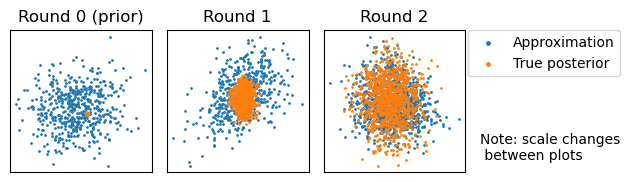

In [14]:
fig, axes = plt.subplots(ncols=len(data["theta"]))

for r, (ax, samps) in enumerate(zip(axes, data["theta"])):
    ax.scatter(samps[:, 0], samps[:, 1], s=1, label="Approximation")
    ax.scatter(reference_posterior[:, 0], reference_posterior[:, 1], s=1, label="True posterior")
    title = "Round 0 (prior)" if r==0 else f"Round {r}"
    ax.set_title(title)
    ax.set_box_aspect(1)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

lgnd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for handle in lgnd.legend_handles:
    handle.set_sizes([6.0])

plt.tight_layout()
plt.text(0.65, -0.3, "Note: scale changes \n between plots")
